## Single Spectrum-sp500logreturn-daily

In [1]:
import numpy as np
np.random.seed(30821)

import cv2
import os
from PIL import Image
import keras

In [2]:
os.environ['KERAS_BACKEND']='tensorflow'

image_directory='/Users/luzhang/Desktop/sp500_spectrum/'
SIZE=64
dataset=[]
label=[]

In [3]:
up_images=os.listdir(image_directory+'upspectrum/')
for i, image_name in enumerate(up_images):
        if(image_name.split('.')[1]=='png'):
                image=cv2.imread(image_directory+'upspectrum/'+image_name)
                image=Image.fromarray(image, 'RGB')
                image=image.resize((SIZE, SIZE))
                dataset.append(np.array(image))
                label.append(1)
                
down_images=os.listdir(image_directory+'downspectrum/')
for i, image_name in enumerate(down_images):
        if(image_name.split('.')[1]=='png'):
                image=cv2.imread(image_directory+'downspectrum/'+image_name)
                image=Image.fromarray(image, 'RGB')
                image=image.resize((SIZE, SIZE))
                dataset.append(np.array(image))
                label.append(0)

In [4]:
INPUT_SHAPE=(SIZE,SIZE,3)# change to (SIZE, SIZE, 3)
inp=keras.layers.Input(shape=INPUT_SHAPE)

conv1=keras.layers.Conv2D(32, kernel_size=(3,3),
                          activation='relu',padding='same')(inp)
pool1=keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
norm1=keras.layers.BatchNormalization(axis=-1)(pool1)
drop1=keras.layers.Dropout(rate=0.2)(norm1)

conv2=keras.layers.Conv2D(32, kernel_size=(3,3),
                          activation='relu',padding='same')(drop1)
pool2=keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
norm2=keras.layers.BatchNormalization(axis=-1)(pool2)
drop2=keras.layers.Dropout(rate=0.2)(norm2)

flat=keras.layers.Flatten()(drop2) # Flatten the matrix to get it ready for density

hidden1=keras.layers.Dense(512, activation='relu')(flat)
norm3=keras.layers.BatchNormalization(axis=-1)(hidden1)
drop3=keras.layers.Dropout(rate=0.2)(norm3)

hidden2=keras.layers.Dense(256, activation='relu')(drop3)
norm4=keras.layers.BatchNormalization(axis=-1)(hidden2)
drop4=keras.layers.Dropout(rate=0.2)(norm4)

out=keras.layers.Dense(2,activation='sigmoid')(drop4) # units=1 gives errors

model=keras.Model(inputs=inp, outputs=out)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',# Check between binary_crossent
              metrics=['accuracy'])

print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0     

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test=train_test_split(dataset, to_categorical(np.array(label)), test_size=0.3, random_state=0)

history=model.fit(np.array(X_train), y_train, batch_size=32, verbose=1, epochs=50,validation_split=0.1, shuffle=False)


Epoch 1/50
61/61 [==============================] - 5s 64ms/step - loss: 1.0186 - accuracy: 0.5465 - val_loss: 0.8784 - val_accuracy: 0.5442
Epoch 2/50
61/61 [==============================] - 4s 58ms/step - loss: 0.7997 - accuracy: 0.5761 - val_loss: 0.9415 - val_accuracy: 0.6047
Epoch 3/50
61/61 [==============================] - 4s 59ms/step - loss: 0.7083 - accuracy: 0.6213 - val_loss: 0.8843 - val_accuracy: 0.5953
Epoch 4/50
61/61 [==============================] - 4s 62ms/step - loss: 0.6845 - accuracy: 0.6219 - val_loss: 0.7148 - val_accuracy: 0.5860
Epoch 5/50
61/61 [==============================] - 4s 59ms/step - loss: 0.5888 - accuracy: 0.6885 - val_loss: 0.6694 - val_accuracy: 0.6512
Epoch 6/50
61/61 [==============================] - 4s 59ms/step - loss: 0.5812 - accuracy: 0.7046 - val_loss: 0.7871 - val_accuracy: 0.5767
Epoch 7/50
61/61 [==============================] - 4s 59ms/step - loss: 0.5893 - accuracy: 0.6902 - val_loss: 0.6887 - val_accuracy: 0.6326
Epoch 8/50
61

In [6]:
print("Test_Accuracy: {:.22f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

29/29 [==============================] - 0s 14ms/step - loss: 1.5798 - accuracy: 0.5939
Test_Accuracy: 59.3919634819030761718750%


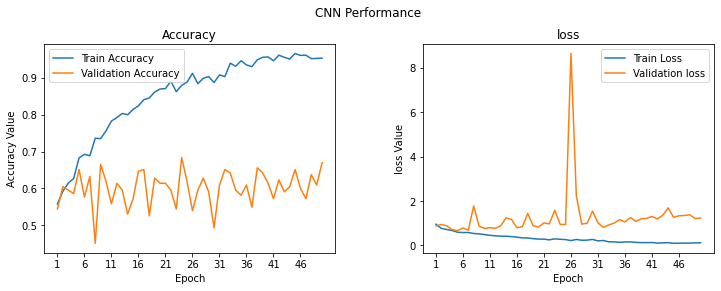

In [7]:
import matplotlib.pyplot as plt
f, (ax1, ax2) =plt.subplots(1,2,figsize=(12,4))
t=f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch=len(history.history['accuracy'])+1
epoch_list=list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label="Validation Accuracy")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1=ax1.legend(loc='best')

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label="Validation loss")
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('loss')
l2=ax2.legend(loc='best')

model.save("CMO_attempt_CNN.h5")


## Dual-input DVI, DPO

In [8]:
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [ ]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.4)(model)
    
  return model

In [ ]:

current_input = Input(shape=input_shape)
current_model = create_convolution_layers(current_input)

voltage_input = Input(shape=input_shape)
voltage_model = create_convolution_layers(voltage_input)

conv = concatenate([current_model, voltage_model])

conv = Flatten()(conv)

dense = Dense(512)(conv)
dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[current_input, voltage_input], outputs=[output])

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])